# Plot recent Nextstrain 2-year tree and color based on site 145 identity 

In [1]:
from IPython.display import HTML
import re
import copy
import pandas as pd
import baltic as bt
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex
from matplotlib.colorbar import ColorbarBase


import numpy as np
import itertools
import requests


from io import StringIO as sio
from io import BytesIO as csio

import json
import Bio.Phylo
import Bio.SeqIO
from Bio import Phylo
import ete3

typeface='sans'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [2]:
# Input and output directories
datadir = 'data/'
resultsdir = 'results/'

os.makedirs(datadir, exist_ok=True)
os.makedirs(resultsdir, exist_ok=True)

# Basic color palette
color_palette = [
    '#345995', #blue
    '#03cea4', #teal
    '#ca1551', #red
    '#eac435', #yellow
               ]

In [3]:
# Identify treefile
# json_treefile = './data/flu_seasonal_h3n2_ha_2y_dowloaded250109.json'
json_treefile = './data/flu_seasonal_h3n2_ha_2y_dowloaded250218.json'

# JSON translation
json_translation = {
    'absoluteTime': lambda k: k.traits['node_attrs']['num_date']['value'], 
    'name': 'name',
} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

print('Loading original tree...')
ll, meta = bt.loadJSON(json_treefile,
                       json_translation=json_translation) ## give loadJSON the name of the tree file, the translation dictionary and (optionally) the meta file

# Prune a weird strain 'A/Belgium/S0576/2023', belonging to subclade 'A'
# Also remove pre-2020 strains
print('Pruning tree...')
# The 'A/Belgium/S0576/2023' strain was behaving super weirdly, seemed misattributed to subclade
keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name != 'A/Belgium/S0576/2023' and int(k.name.split('/')[-1].split('-')[0]) > 2020] ## list of leaf objects that will remain in the tree - here only circulating strains in library
ll=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
ll.treeStats() # Print tree stats

## MRCA of recent tree
print('Getting subtree of 2020 and more recent strains...')
ancestor = ll.commonAncestor(keep_tips)
ancestor

# Get subtree
ll_recent = ll.subtree(k=ancestor, ## Will only traverse through children in the same trait state as the starting node
                      stem=False # Trim tree stem
                             ) 
ll_recent.treeStats() # Print tree stats


Loading original tree...

Tree height: 11.163000
Tree length: 778.394000
annotations present

Numbers of objects in tree: 5506 (2611 nodes and 2895 leaves)

Pruning tree...

Tree height: 11.163000
Tree length: 743.928000
multitype tree
annotations present

Numbers of objects in tree: 5398 (2567 nodes and 2831 leaves)

Getting subtree of 2020 and more recent strains...

Tree height: 5.738000
Tree length: 741.706000
annotations present

Numbers of objects in tree: 5404 (2560 nodes and 2844 leaves)



In [4]:
# Find all the 145 mutation branches and leaves

# Trying to label nodes with mutations
N_nodes = []
S_nodes = []
G_nodes = []
R_nodes = []


# Get names and attrs of branches
for k in ll.Objects: ## iterate over tips
    node, subclade, haplotype = ([k.name, k.traits['node_attrs']['subclade']['value'], 
                                 k.traits['node_attrs']['haplotype']['value']])
    mutations = k.traits['branch_attrs']['labels']['aa'] if 'HA1' in k.traits['branch_attrs']['mutations'] else 'nan'
        
    # 145N
    if '145N' in mutations:
        # print(node, subclade, haplotype, mutations)
        N_nodes.append(node)

    # 145G
    if '145G' in mutations:
        # print(node, subclade, haplotype, mutations)
        G_nodes.append(node)  

    # 145R
    if '145R' in mutations:
        # print(node, subclade, haplotype, mutations)
        R_nodes.append(node)  

    # 145S
    elif '145S' in mutations:
        # print(node, subclade, haplotype, mutations)
        S_nodes.append(node)  


# Load the JSON tree structure
with open(json_treefile, 'r') as f:
    tree_data = json.load(f)

# Build tree with branch attributes
def build_phylo_tree(node):
    clade_name = node.get('name', '')
    clade = Phylo.BaseTree.Clade(name=clade_name)
    clade.branch_attrs = node.get("branch_attrs", {})
    
    # If the node has children, create them recursively
    if 'children' in node:
        clade.clades = [build_phylo_tree(child) for child in node['children']]
    return clade

# Build the phylo tree from the JSON data
tree = build_phylo_tree(tree_data["tree"])

# Function to get all descendant nodes, edges, and leaves
def get_descendants_with_edges(clade, parent_name=None):
    descendants = []
    if clade.clades:
        for child in clade.clades:
            # Add the edge (parent -> child) info
            if parent_name:
                edge = (parent_name, clade.name, child.name)
                descendants.append(('edge', edge))
            descendants.append(('node', clade.name))  # Record current node
            descendants.extend(get_descendants_with_edges(child, parent_name=clade.name))
    else:
        descendants.append(('leaf', clade.name))  # Record leaf
    return descendants

# Traverse the tree to identify nodes and get all descendant nodes, branches, and leaves
N_descendants = []
S_descendants = []
G_descendants = []
R_descendants = []

for n in tree.find_clades():
    
    if n.name in N_nodes:
        N_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                N_descendants.append(desc[1])
            elif desc[0] == 'edge':
                N_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                N_descendants.append(desc[1])

    elif n.name in S_nodes:
        S_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                S_descendants.append(desc[1])
            elif desc[0] == 'edge':
                S_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                S_descendants.append(desc[1])

    elif n.name in G_nodes:
        G_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                G_descendants.append(desc[1])
            elif desc[0] == 'edge':
                G_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                G_descendants.append(desc[1])

    elif n.name in R_nodes:
        R_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                R_descendants.append(desc[1])
            elif desc[0] == 'edge':
                R_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                R_descendants.append(desc[1])

N_descendants = (list(set(N_descendants)))
S_descendants = (list(set(S_descendants)))
G_descendants = (list(set(G_descendants)))
R_descendants = (list(set(R_descendants)))

In [5]:
# Make list of subclades to label based on where 145N mutations are
subclades_to_label = [
    'G',
    'G,1', 
    'G.1.1',
    'G.1.3',
    'G.2',
    'J',
    'J.1',
    'J.2',
    'J.2.1',
    'J.2.2',
    'J.3',
    'J.4'
]

nodes_to_label = []

N_subclades = []

for k in ll.Objects:
    name = k.name
    subclade = (k.traits['node_attrs']['subclade']['value'])

    if subclade in subclades_to_label:
        nodes_to_label.append(name)
        subclades_to_label.remove(subclade)

    if name in N_descendants:
        N_subclades.append([name, subclade])

    if 'accession_ha' in k.traits['node_attrs']:
        accession = (k.traits['node_attrs']['accession_ha']['value'])
        
        if accession == 'EPI3741324':
            print(name, k.traits['node_attrs'])
            print(name)

        if 'WestVirginia' in name:
            print(name, accession)

        # A/StPetersburg/RII-60/2024
        
#N_subclades

A/WestVirginia/30/2023 EPI2813152
A/WestVirginia/32/2023 EPI2813136
A/WestVirginia/47/2024 EPI3431437
A/WestVirginia/55/2024 EPI3552184
A/StPetersburg/RII-60/2024 {'div': 0.0476, 'num_date': {'value': 2024.911, 'confidence': [2024.911, 2024.911]}, 'gisaid_strain': {'value': 'A/Saint-Petersburg/RII-60/2024'}, 'accession_ha': {'value': 'EPI3741324'}, 'accession_na': {'value': 'EPI3741323'}, 'cTiterSub': {'value': 9.348}, 'subclade': {'value': 'J.2'}, 'clade_membership': {'value': '2a.3a.1'}, 'country': {'value': 'Russia'}, 'region': {'value': 'West Asia', 'confidence': {'West Asia': 1.0}, 'entropy': -1e-12}, 'haplotype': {'value': 'J.2'}, 'rb': {'value': 5.0}, 'tsne_x': {'value': '-6.052716527262549'}, 'cTiter': {'value': 5.355}, 'proposed_subclade': {'value': 'J.2'}, 'submitting_lab': {'value': 'Who National Influenza Centre Russian Federation'}, 'year_month': {'value': '2024-11'}, 'ne_star': {'value': 2.0}, 'originating_lab': {'value': 'Who National Influenza Centre Russian Federation'

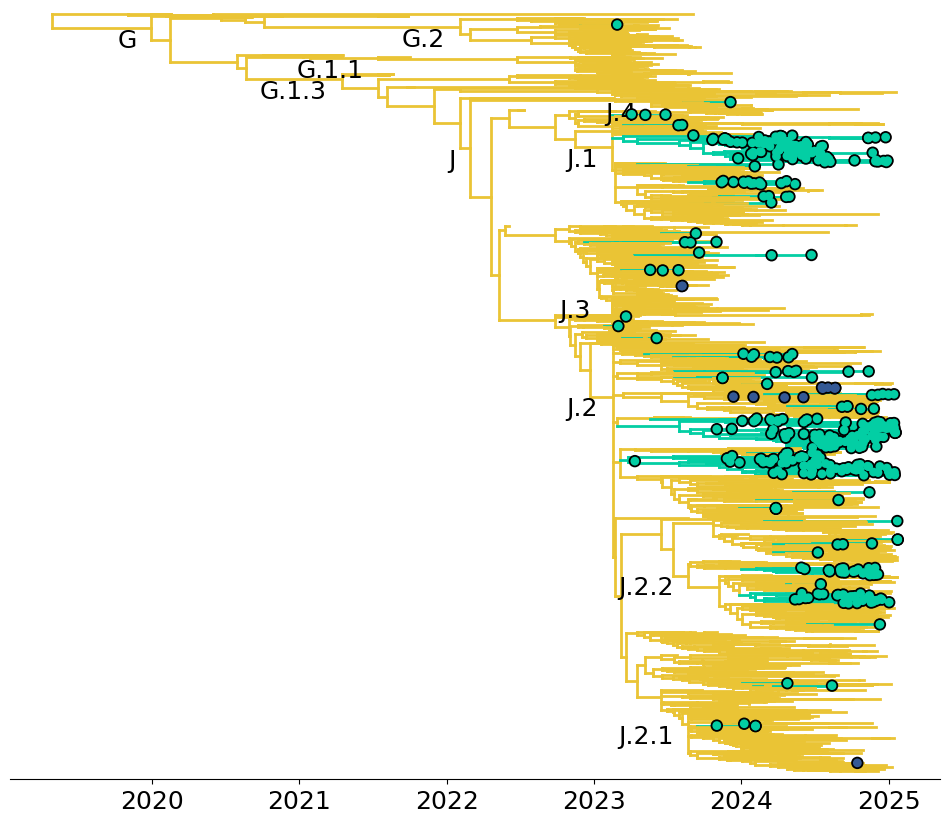

In [6]:
plt.close()
fig = plt.figure(figsize=(12,10),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

# colors and sizes for branches and points
point_size = (lambda k: 40 if k.name in N_descendants else 40 if k.name in G_descendants else 0)
point_colour = (lambda k: color_palette[1] if k.name in N_descendants else color_palette[0] if k.name in G_descendants else color_palette[3])
branch_colour = lambda k: color_palette[1] if k.name in N_descendants else color_palette[3]  ## colour red if vaccine strain, blue if circulating, otherwise black

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

ll_recent.plotTree(ax,
            x_attr=x_attr,
            colour= branch_colour,
            linewidths = 0.01,
            zorder=1) ## plot collapsed tree
ll_recent.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=18)
# Y-axis limit
ax.set_ylim(-30,ll.ySpan+30)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])

# Attempt node text
text_x_attr=lambda k: k.absoluteTime-0.1 ## shift text back
text_y_attr=lambda k: k.y-0.5 ## shift text down
target_func=lambda k: k.is_node() and k.name in nodes_to_label ## annotate nodes with posterior >0.95 and >100 descendant tips
text_func=lambda k: (k.traits['node_attrs']['subclade']['value']) ## what text is plotted
kwargs={'va':'top','ha':'right','size': 18,} ## kwargs for text

ll_recent.addText(ax,x_attr=text_x_attr,y_attr=text_y_attr,target=target_func,text=text_func,**kwargs)


plt.draw()

# Save plot
outfile = os.path.join('./results/145N_tree.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

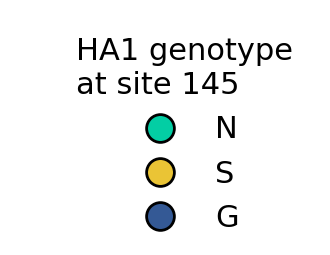

In [7]:
# Make legend
plt.close()

fig = plt.figure(figsize=(4,1),facecolor='w') ## create figure

tree_key = {

    'N':  color_palette[1],
    'S': color_palette[3], # palette yellow
    'G': color_palette[0], # palette blue
    # 'R': color_palette[2], # palette red

                   }


# draw a legend for the country to color mapping
# for circles: https://stackoverflow.com/a/44113141
patches = [plt.plot([], [], marker='o', markeredgecolor = 'black', markeredgewidth=2, ms=20, ls='', color=color, label=strain)[0]
           for strain, color in tree_key.items()]
plt.gca().set_axis_off()
legend = plt.legend(handles=patches,
                    loc='best',
                    title = 'HA1 genotype\nat site 145',
                    frameon=False,
                    prop={'family': 'Sans'}
                   )

# draw just legend https://stackoverflow.com/a/47749903
tree_legend = './results/145N_legend.png'
fig = legend.figure
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(tree_legend, bbox_inches='tight', dpi=600)